# Session 6: Encoder-Decoder
---

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


## Import libraries

In [ ]:
# Download these NLTK packages
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import nltk, time
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from nltk.stem import WordNetLemmatizer
import collections, itertools

In [3]:
import os

base_path = 'gdrive/MyDrive/TSAI_END2/Session6/'
data_path = base_path + 'data/'
data_filename = 'tweets.csv'

## Dataset Creation
---

In [4]:
import pandas as pd

tweets_data = pd.read_csv(os.path.join(data_path,data_filename))

In [5]:
tweets_data

,tweets,labels
0,Obama has called the GOP budget social Darwini...,1
1,"In his teen years, Obama has been known to use...",0
2,IPA Congratulates President Barack Obama for L...,0
3,RT @Professor_Why: #WhatsRomneyHiding - his co...,0
4,RT @wardollarshome: Obama has approved more ta...,1
...,...,...
1359,@liberalminds Its trending idiot.. Did you loo...,0
1360,RT @AstoldByBass: #KimKardashiansNextBoyfriend...,0
1361,RT @GatorNation41: gas was $1.92 when Obama to...,1
1362,"@xShwag haha i know im just so smart, i mean y...",1


### EDA
---

In [ ]:
tweets_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1364 entries, 0 to 1363
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweets  1364 non-null   object
 1   labels  1364 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 21.4+ KB


In [ ]:
tweets_data.value_counts()

tweets                                                                                                                                                       labels
RT @ohgirlphrase: American kid "You're from the UK? Ohhh cool, So do you have tea with the Queen?". British kid: "Do you like, go to Mcdonalds with Obama?   0         86
In his teen years, Obama has been known to use marijuana and cocaine.                                                                                        0         15
Obama has called the GOP budget social Darwinism. Nice try, but they believe in social creationism.                                                          1         15
RT @Talkmaster: Oh now I get it. Obama was talking in shorthand and we were just too dumb to understand how smart he really is.  Gagme.                      1          9
RT @markknoller: AT a campaign fundraiser tonight, Pres. Obama again denounced Mitt Romney by name for his support of the House-passed GOP Budget.          

In [ ]:
unique_tweets_data = tweets_data.value_counts().reset_index()
unique_tweets_data.columns = ['tweets','labels','count']
unique_tweets_data

,tweets,labels,count
0,"RT @ohgirlphrase: American kid ""You're from th...",0,86
1,"In his teen years, Obama has been known to use...",0,15
2,Obama has called the GOP budget social Darwini...,1,15
3,RT @Talkmaster: Oh now I get it. Obama was tal...,1,9
4,RT @markknoller: AT a campaign fundraiser toni...,1,9
...,...,...,...
1045,RT @BuckSexton: interesting to see how Obama a...,0,1
1046,RT @Boudicabpi: Michael Savage: How Obama plan...,0,1
1047,RT @Blondiecakess: Obama's skin color is not a...,1,1
1048,RT @BarackObama: Watch live: President Obama s...,1,1


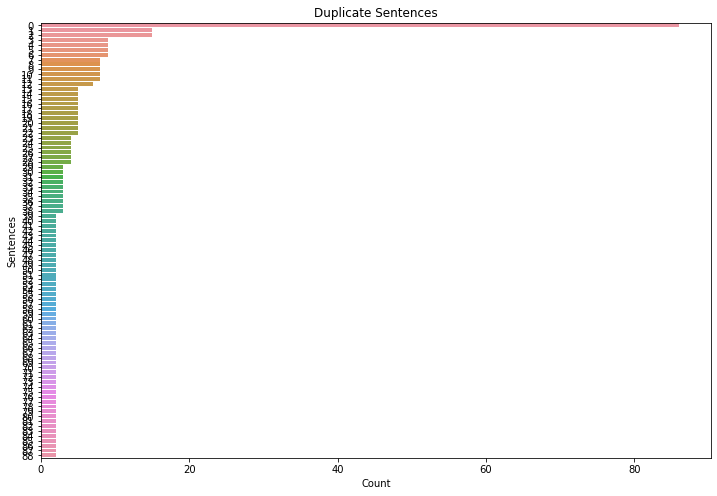

In [ ]:
fig = plt.figure(figsize=(12,8))
fig = sns.barplot(x=unique_tweets_data[unique_tweets_data['count']>1]['count'], y=[str(i) for i in range(len(unique_tweets_data[unique_tweets_data['count']>1]))])
fig = plt.xlabel("Count")
fig = plt.ylabel('Sentences')
fig = plt.title('Duplicate Sentences')
plt.show()

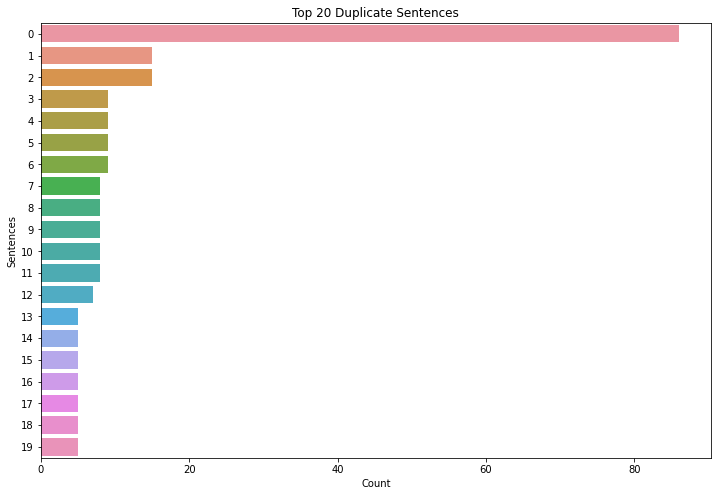

In [ ]:
fig = plt.figure(figsize=(12,8))
fig = sns.barplot(x=unique_tweets_data[:20]['count'], y=[str(i) for i in range(20)])
fig = plt.xlabel("Count")
fig = plt.ylabel('Sentences')
fig = plt.title('Top 20 Duplicate Sentences')
plt.show()

In [ ]:
tweets_data[tweets_data['tweets'] == unique_tweets_data.loc[0,'tweets']]

,tweets,labels
7,"RT @ohgirlphrase: American kid ""You're from th...",0
15,"RT @ohgirlphrase: American kid ""You're from th...",0
22,"RT @ohgirlphrase: American kid ""You're from th...",0
40,"RT @ohgirlphrase: American kid ""You're from th...",0
49,"RT @ohgirlphrase: American kid ""You're from th...",0
...,...,...
911,"RT @ohgirlphrase: American kid ""You're from th...",0
919,"RT @ohgirlphrase: American kid ""You're from th...",0
973,"RT @ohgirlphrase: American kid ""You're from th...",0
1158,"RT @ohgirlphrase: American kid ""You're from th...",0


In [ ]:
# Function to tokenize the tweets
def custom_tokenize(text, tokenize=False):
    """Function that tokenizes text"""
    from nltk.tokenize import word_tokenize
    if not text:
        print('The text to be tokenized is a None type. Defaulting to blank string.')
        text = ''
    if tokenize:
      return word_tokenize(text)
    else:
      return text.split(' ')

# Function that applies the cleaning steps
def clean_up(data1):
    """Function that cleans up the data into a shape that can be further used for modeling"""
    data = data1.copy()
    data.drop_duplicates(inplace=True) # drop duplicate tweets
    tokenized = data['tweets'].apply(custom_tokenize) # Tokenize tweets
    lower_tokens = tokenized.apply(lambda x: [t.lower() for t in x]) # Convert tokens into lower case
    alpha_only = lower_tokens.apply(lambda x: [t for t in x if t.isalpha()]) # Remove punctuations
    no_stops = alpha_only.apply(lambda x: [t for t in x if t not in stopwords.words('english')]) # remove stop words
    no_stops.apply(lambda x: [x.remove(t) for t in x if t=='rt']) # remove acronym "rt"
    no_stops.apply(lambda x: [x.remove(t) for t in x if t=='https']) # remove acronym "https"
    no_stops.apply(lambda x: [x.remove(t) for t in x if t=='twitter']) # remove the word "twitter"
    no_stops.apply(lambda x: [x.remove(t) for t in x if t=='retweet'])
    data['cleaned_tweets'] = no_stops
    return data

In [ ]:
clean_up(tweets_data)

,tweets,labels,cleaned_tweets
0,Obama has called the GOP budget social Darwini...,1,"[obama, called, gop, budget, social, darwinism..."
1,"In his teen years, Obama has been known to use...",0,"[teen, years, obama, known, use, marijuana, co..."
2,IPA Congratulates President Barack Obama for L...,0,"[ipa, congratulates, president, barack, obama,..."
3,RT @Professor_Why: #WhatsRomneyHiding - his co...,0,"[whatsromneyhiding, connection, supporters, cr..."
4,RT @wardollarshome: Obama has approved more ta...,1,"[wardollarshome, obama, approved, targeted, as..."
...,...,...,...
1359,@liberalminds Its trending idiot.. Did you loo...,0,"[liberalminds, trending, look, tweets, lol, ma..."
1360,RT @AstoldByBass: #KimKardashiansNextBoyfriend...,0,"[astoldbybass, kimkardashiansnextboyfriend, ba..."
1361,RT @GatorNation41: gas was $1.92 when Obama to...,1,"[gas, obama, took, office, guess, promise, wou..."
1362,"@xShwag haha i know im just so smart, i mean y...",1,"[xshwag, haha, know, im, smart, mean, got, ta,..."


## Dataset Creation
---

In [6]:
# Import Library
import random
import torch, torchtext
from torchtext.legacy import data 

# Manual Seed
SEED = 42
torch.manual_seed(SEED)

In [7]:
Tweet = data.Field(sequential = True, tokenize = 'spacy', batch_first =True)#, include_lengths=True)
Label = data.LabelField(dtype = torch.int64)

In [8]:
fields = [('tweets', Tweet),('labels',Label)]

In [9]:
example = [data.Example.fromlist([tweets_data.tweets[i],tweets_data.labels[i]], fields) for i in range(tweets_data.shape[0])] 

In [10]:
twitterDataset = data.Dataset(example, fields)

In [11]:
(train_data, valid_data) = twitterDataset.split(split_ratio=[0.85, 0.15], random_state=random.seed(SEED))

In [12]:
(len(train_data), len(valid_data))

(1159, 205)

In [13]:
vars(train_data.examples[10])

{'labels': 0,
 'tweets': ['Obama',
  'vs',
  'Romney&gt;Obama',
  'helped',
  'the',
  'Auto',
  'Industry',
  ',',
  'Prevented',
  'a',
  'deeper',
  'recession',
  '/',
  'created',
  '3',
  '+',
  'million',
  'jobs&lt;Romney',
  'ca',
  'nt',
  'win',
  'on',
  'this',
  'issue',
  '#',
  'p2',
  '#',
  'tcot']}

In [14]:
Tweet.build_vocab(train_data)
Label.build_vocab(train_data)

In [15]:
print('Size of input vocab : ', len(Tweet.vocab))
print('Size of label vocab : ', len(Label.vocab))
print('Top 10 words appreared repeatedly :', list(Tweet.vocab.freqs.most_common(10)))
print('Labels : ', Label.vocab.stoi)

Size of input vocab :  4731
Size of label vocab :  3
Top 10 words appreared repeatedly : [('Obama', 1052), ('#', 822), (':', 784), ('.', 775), (',', 616), ('"', 553), ('the', 546), ('RT', 512), ('?', 404), ('to', 402)]
Labels :  defaultdict(None, {0: 0, 1: 1, 2: 2})


In [16]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [17]:
train_iterator, valid_iterator = data.BucketIterator.splits((train_data, valid_data), batch_size = BATCH_SIZE, 
                                                            sort_key = lambda x: len(x.tweets),
                                                            sort_within_batch=True, device = device)

In [18]:
import os, pickle
with open(os.path.join(data_path,'tokenizer.pkl'), 'wb') as tokens: 
    pickle.dump(Tweet.vocab.stoi, tokens)

## Model Building

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

#### Encoder

In [206]:
class EncoderLSTM(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers=1):
    super().__init__()
    self.hidden_dim = hidden_dim
    self.n_layers = n_layers
    # embedding layer
    self.embedding = nn.Embedding(vocab_size, embedding_dim)

    # lstm layer
    self.lstm = nn.LSTM(embedding_dim, 
                        hidden_dim,
                        num_layers=n_layers,
                        batch_first=True)
    
    self.enc_context = nn.Linear(hidden_dim, output_dim)
  
  def initHidden(self, batch_size, device):
    return (torch.zeros(1, batch_size, self.hidden_dim, device=device), torch.zeros(1, batch_size, self.hidden_dim, device=device))

  def forward(self, text, enc_hidden, visualize=False, verbose=False):
    # hidden, cell = enc_hidden
    embedded = self.embedding(text)
    
    lstm_output, (hidden, cell) = self.lstm(embedded, enc_hidden)
    
    output = self.enc_context(hidden.squeeze(0))
    
    if verbose:
      print('inside encoder:-')
      print(f'shape of text input to encoder: {text.shape}')
      print(f'shape of Embedding layer output: {embedded.shape}')
      print(f'shape of lstm layer output: {hidden.shape}')
      print(f'shape of fc layer output: {output.shape}')
      print(f'shape of encoder output: {output.shape}')

    if visualize:
      enc_op = lstm_output[0].detach().cpu().numpy()
      fig, ax = plt.subplots(figsize=(20,10)) 
      sns.heatmap(enc_op, fmt=".2f", vmin=-1, vmax=1, annot=True, cmap="YlGnBu", ax=ax)
      plt.title('Hidden State in each time step of Encoder', fontsize = 20) # title with fontsize 20
      plt.xlabel('Hidden state', fontsize = 15) # x-axis label with fontsize 15
      plt.ylabel('Time Step', fontsize = 15) # y-axis label with fontsize 15
      plt.show()

      enc_op = output.detach().cpu().numpy()
      fig, ax = plt.subplots(figsize=(20,4)) 
      sns.heatmap(enc_op, fmt=".2f", vmin=-1, vmax=1, annot=True, cmap="YlGnBu", ax=ax, annot_kws={"size": 20})
      plt.title('Encoded Representation from Encoder', fontsize = 20) # title with fontsize 20
      plt.show()

    return output, (hidden, cell)

#### Decoder

In [207]:
class DecoderLSTM(nn.Module):
  def __init__(self, enc_dim, hidden_dim, output_dim, n_layers=1):
    super().__init__()

    # lstm layer
    self.lstm = nn.LSTMCell(enc_dim, 
                        hidden_dim,
                        bias=False)
                        # num_layers=n_layers,
                        # batch_first=True)
    
    self.decoded_op = nn.Linear(hidden_dim, output_dim)
  
  def forward(self, enc_context, enc_hidden, dec_steps=2, visualize=False, verbose=False):
    dec_input = enc_context.unsqueeze(1)
    hidden, cell = enc_hidden
    hidden = hidden.squeeze(0)
    cell = cell.squeeze(0)
    dec_outputs = []
    for i in range(dec_steps):
      hidden, cell = self.lstm(enc_context, (hidden, cell))
      dec_outputs.append(hidden)
    dec_output = torch.stack(dec_outputs, dim=1)
        
    output = self.decoded_op(hidden)

    if verbose:
      print('inside decoder:-')
      print(f'shape of output from encoder which goes as input to decoder: {enc_context.shape}')
      print(f'shape of lstm layer output: {hidden.shape}')
      print(f'shape of fc layer output: {output.shape}')
      print(f'shape of decoder output: {output.shape}')

    if visualize:
      enc_op = dec_output[0].detach().cpu().numpy()
      fig, ax = plt.subplots(figsize=(50,4)) 
      sns.heatmap(enc_op, fmt=".2f", vmin=-1, vmax=1, annot=True, cmap="YlGnBu", ax=ax, annot_kws={"size": 20})
      plt.title('Hidden State in each time step of Decoder', fontsize = 20) # title with fontsize 20
      plt.xlabel('Hidden State', fontsize = 15) # x-axis label with fontsize 15
      plt.ylabel('Time Step', fontsize = 15) # y-axis label with fontsize 15
      plt.show()

      enc_op = output.detach().cpu().numpy()
      fig, ax = plt.subplots(figsize=(20,4)) 
      sns.heatmap(enc_op, fmt=".2f", vmin=-1, vmax=1, annot=True, cmap="YlGnBu", ax=ax, annot_kws={"size": 20})
      plt.title('Decoded Representation from Decoder', fontsize = 20) # title with fontsize 20
      plt.show()
    return output

#### Encoder Decoder Model

In [208]:
class LSTMEncoderDecoderClassifier(nn.Module):
    
    # Define all the layers used in model
    def __init__(self, device, vocab_size, embedding_dim, hidden_enc_dim, hidden_dec_dim, context_dim, output_dim, n_classes, n_enc_layers=1, n_dec_layers=1):
        # Constructor
        super().__init__()
        self.device = device

        # encoder layer
        self.encoder = EncoderLSTM(vocab_size, embedding_dim, hidden_enc_dim, context_dim, n_enc_layers)

        # decoder layer
        self.decoder = DecoderLSTM(context_dim, hidden_dec_dim, output_dim, n_dec_layers)

        # output layer
        self.linear_output = nn.Linear(output_dim, n_classes)

    def forward(self, text, dec_steps=2, visualize=False, verbose=False): #, text_lengths):
        # text = [batch size,sent_length]
        enc_h = self.encoder.initHidden(text.shape[0], self.device)
        
        encoded_context, encoded_hidden = self.encoder(text, enc_h, visualize, verbose)#, text_lengths)
        decoded = self.decoder(encoded_context, encoded_hidden, dec_steps, visualize, verbose)
        prediction = self.linear_output(decoded)

        if verbose:
          print(f'shape of final output: {prediction.shape}')

        if visualize:
          enc_op = prediction.detach().cpu().numpy()
          fig, ax = plt.subplots(figsize=(20,4)) 
          sns.heatmap(enc_op, fmt=".2f", vmin=-1, vmax=1, annot=True, cmap="YlGnBu", ax=ax)#.set(title=f"Encoded Representation from Encoder")
          plt.title('Final Prediction', fontsize = 20) # title with fontsize 20
          plt.show()
        
        return prediction

In [209]:
# Define hyperparameters
size_of_vocab = len(Tweet.vocab)

embedding_dim = 100
hidden_enc_dim = 24
hidden_dec_dim = 24
context_dim = 16
output_dim = 16
n_classes = 3
n_enc_layers = 1
n_dec_layers = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate the model
model = LSTMEncoderDecoderClassifier(device, size_of_vocab, embedding_dim, hidden_enc_dim, hidden_dec_dim, context_dim, output_dim, n_classes, n_enc_layers, n_dec_layers)

In [210]:
print(model)

#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')

LSTMEncoderDecoderClassifier(
  (encoder): EncoderLSTM(
    (embedding): Embedding(4731, 100)
    (lstm): LSTM(100, 24, batch_first=True)
    (enc_context): Linear(in_features=24, out_features=16, bias=True)
  )
  (decoder): DecoderLSTM(
    (lstm): LSTMCell(16, 24, bias=False)
    (decoded_op): Linear(in_features=24, out_features=16, bias=True)
  )
  (linear_output): Linear(in_features=16, out_features=3, bias=True)
)
The model has 489,887 trainable parameters


## Model Training and Testing
---

In [211]:
import torch.optim as optim

# define optimizer and loss
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

# define metric
def categorical_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    top_pred = preds.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc
    
# push to cuda if available
model = model.to(device)
criterion = criterion.to(device)

In [212]:
def train(model, iterator, optimizer, criterion):
    
    # initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    # set the model in training phase
    model.train()  
    
    for batch in iterator:
        # print(batch.tweets.shape)
        # resets the gradients after every batch
        optimizer.zero_grad()   
        
        # retrieve text and no. of words
        text = batch.tweets #, text_lengths = batch.tweet   
        
        # convert to 1D tensor
        predictions = model(text)#, text_lengths)
        # print('in train')
        # print(predictions.shape)
        # print(batch.labels.shape)
        # compute the loss
        loss = criterion(predictions, batch.labels)        
        
        # compute the categorical accuracy
        acc = categorical_accuracy(predictions, batch.labels)   
        
        # backpropage the loss and compute the gradients
        loss.backward()       
        
        # update the weights
        optimizer.step()      
        
        # loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item()    
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [213]:
def evaluate(model, iterator, criterion):
    
    # initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    # deactivating dropout layers
    model.eval()
    
    # deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
        
            # retrieve text and no. of words
            text = batch.tweets  #, text_lengths = batch.text   
            
            # convert to 1D tensor
            predictions = model(text).squeeze(1) #, text_lengths).squeeze(1)
            
            # compute loss and accuracy
            loss = criterion(predictions, batch.labels)
            acc = categorical_accuracy(predictions, batch.labels)
            
            # keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [214]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [215]:
N_EPOCHS = 10
best_valid_loss = float('inf')
train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

for epoch in range(N_EPOCHS):
    start_time = time.time()
    # train the model
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    
    # evaluate the model
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # save the best model
    if valid_loss < best_valid_loss or epoch == N_EPOCHS:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), os.path.join(base_path, 'saved_weights.pt'))
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% \n')

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 1.117 | Train Acc: 20.39%
	 Val. Loss: 1.012 |  Val. Acc: 74.22% 

Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.974 | Train Acc: 68.82%
	 Val. Loss: 0.794 |  Val. Acc: 74.61% 

Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.817 | Train Acc: 69.07%
	 Val. Loss: 0.719 |  Val. Acc: 74.61% 

Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.771 | Train Acc: 69.07%
	 Val. Loss: 0.693 |  Val. Acc: 74.61% 

Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.740 | Train Acc: 69.07%
	 Val. Loss: 0.679 |  Val. Acc: 74.61% 

Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.708 | Train Acc: 69.07%
	 Val. Loss: 0.643 |  Val. Acc: 74.61% 

Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.664 | Train Acc: 70.22%
	 Val. Loss: 0.585 |  Val. Acc: 74.61% 

Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.587 | Train Acc: 73.75%
	 Val. Loss: 0.535 |  Val. Acc: 79.69% 

Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.494 | Train Acc: 82.24%
	 Val. Loss: 0.478 |  Val. Acc: 82.81% 

Epoch: 10 

In [216]:
torch.save(model.state_dict(), os.path.join(base_path, 'lepoch10_saved_weights.pt'))

## Visualization
---

In [217]:
# visualize accuracy and loss graph
def visualize_graph(train_losses, train_acc, test_losses, test_acc):
  fig, axs = plt.subplots(2,2,figsize=(15,10))
  axs[0, 0].plot(train_losses)
  axs[0, 0].set_title("Training Loss")
  axs[1, 0].plot(train_acc)
  axs[1, 0].set_title("Training Accuracy")
  axs[0, 1].plot(test_losses)
  axs[0, 1].set_title("Test Loss")
  axs[1, 1].plot(test_acc)
  axs[1, 1].set_title("Test Accuracy")

def visualize_save_train_vs_test_graph(EPOCHS, dict_list, title, xlabel, ylabel, PATH, name="fig"):
  plt.figure(figsize=(20,10))
  #epochs = range(1,EPOCHS+1)
  for label, item in dict_list.items():
    x = np.linspace(1, EPOCHS+1, len(item))
    plt.plot(x, item, label=label)
  
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.legend()
  plt.savefig(PATH+"/"+name+".png")

#### Training and Testing Accuracy and Loss

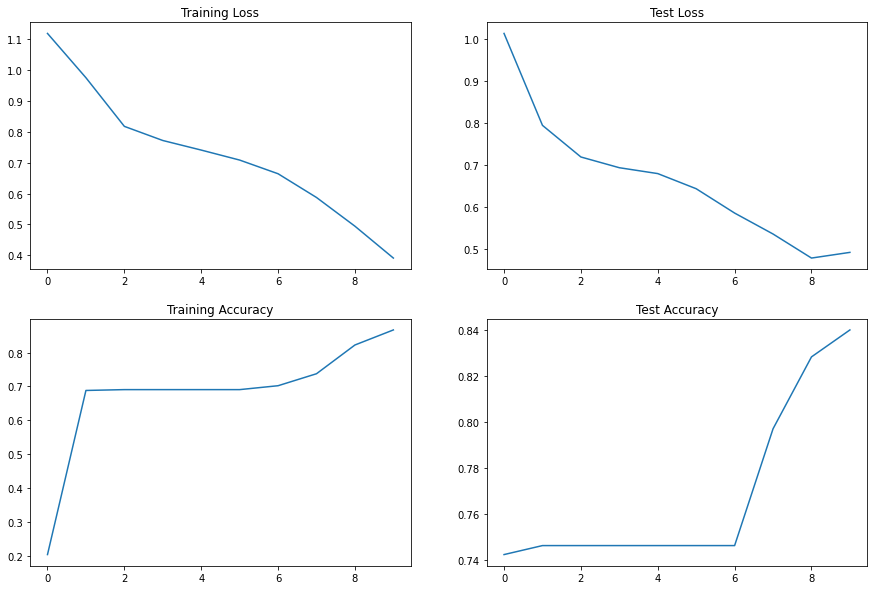

In [218]:
visualize_graph(train_losses, train_accs, valid_losses, valid_accs)

#### Train vs Test Accuracy Comparison

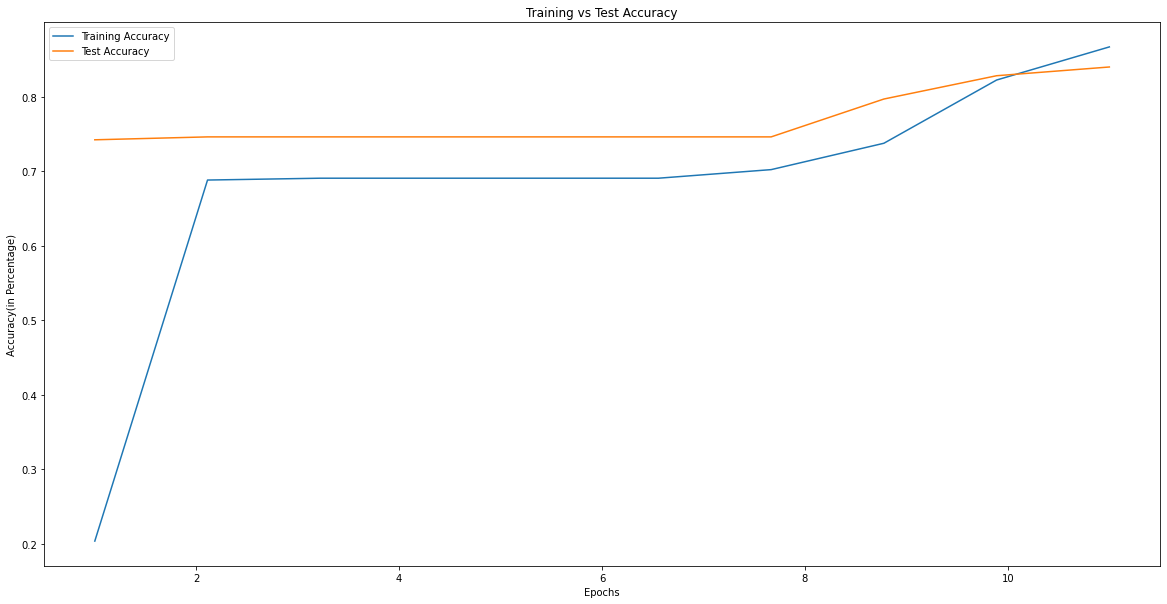

In [219]:
dict_list = {'Training Accuracy': train_accs, 'Test Accuracy': valid_accs}
title = "Training vs Test Accuracy"
xlabel = "Epochs"
ylabel = "Accuracy(in Percentage)"
name = "train_vs_test_acc_comparison_graph"

visualize_save_train_vs_test_graph(N_EPOCHS, dict_list, title, xlabel, ylabel, base_path, name=name)

#### Train vs Test Loss Comparison

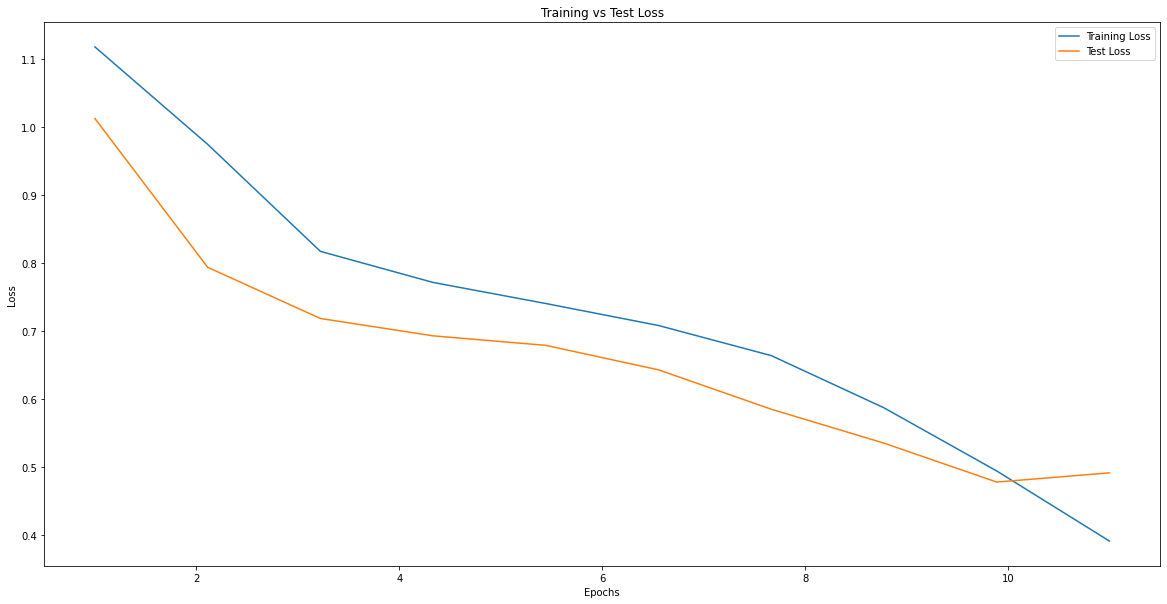

In [220]:
dict_list = {'Training Loss': train_losses, 'Test Loss': valid_losses}
title = "Training vs Test Loss"
xlabel = "Epochs"
ylabel = "Loss"
name = "train_vs_test_loss_comparison_graph"

visualize_save_train_vs_test_graph(N_EPOCHS, dict_list, title, xlabel, ylabel, base_path, name=name)

## Evaluation
---

In [221]:
from sklearn.metrics import f1_score, accuracy_score
def print_accuracy(df, target_col, pred_column):
    "Print f1 score and accuracy after making predictions"
    f1_macro = f1_score(df[target_col].astype(int), df[pred_column].astype(int), average='macro')
    acc = accuracy_score(df[target_col].astype(int), df[pred_column].astype(int))*100
    return f1_macro, acc

In [222]:
def evaluation_pred(model, iterator):
    
    # initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    # deactivating dropout layers
    model.eval()
    eval_df = pd.DataFrame(columns=['label','pred'])
    # deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
        
            # retrieve text and no. of words
            text = batch.tweets  #, text_lengths = batch.text 
            label = batch.labels.cpu().numpy()  
            
            # convert to 1D tensor
            predictions = model(text)
            top_pred = predictions.argmax(1, keepdim = True).cpu().numpy()
            batch_df = pd.DataFrame(top_pred, columns=['pred'])
            batch_df['label'] = label
            batch_df['pred'] = batch_df['pred'].astype(int)
            batch_df['label'] = batch_df['label'].astype(int)
            eval_df = pd.concat([eval_df, batch_df])          
        
    return eval_df

In [223]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np


def plot_confusion_matrix(y_true, y_pred, 
                          classes=['Positive','Neutral','Negative'],
                          normalize=False,
                          cmap=plt.cm.YlOrBr):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    (Adapted from scikit-learn docs).
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', origin='lower', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # Show all ticks
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # Label with respective list entries
           xticklabels=classes, yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')

    # Set alignment of tick labels
    plt.setp(ax.get_xticklabels(), rotation=0, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    return fig, ax

In [224]:
import pickle
model.eval()
tokenizer_file = open(os.path.join(data_path,'tokenizer.pkl'), 'rb')
tokenizer = pickle.load(tokenizer_file)

#inference 

import spacy
nlp = spacy.load('en')

def classify_text(tweet, visualize=True, verbose=False):
    
    categories = {0: 0, 1:1, 2:2}
    
    # tokenize the tweet 
    tokenized = [tok.text for tok in nlp.tokenizer(tweet)] 
    # convert to integer sequence using predefined tokenizer dictionary
    indexed = [tokenizer[t] for t in tokenized]        
    # compute no. of words        
    length = [len(indexed)]
    # convert to tensor                                    
    tensor = torch.LongTensor(indexed).to(device)   
    # reshape in form of batch, no. of words           
    tensor = tensor.unsqueeze(1).T  
    print(tensor.shape)
    # convert to tensor                          
    length_tensor = torch.LongTensor(length)
    # Get the model prediction                  
    prediction = model(tensor, visualize=visualize, verbose=verbose) #, length_tensor)
    # print(prediction)

    # _, pred = torch.max(prediction, 1) 
    pred = prediction.argmax(keepdim = True)
    
    return categories[pred.item()]

In [225]:
plt.rcParams["figure.figsize"] = (8,8)

#### Encoder-Decoder Visualization of each step


Obama has called the GOP budget social Darwinism. Nice try, but they believe in social creationism.
Target Label: 1
torch.Size([1, 19])


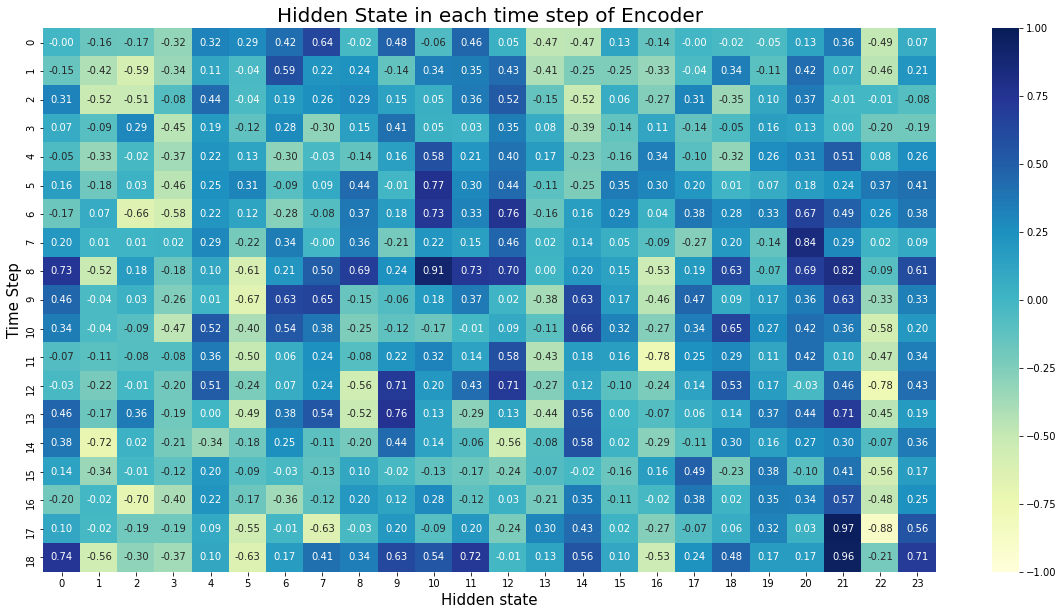

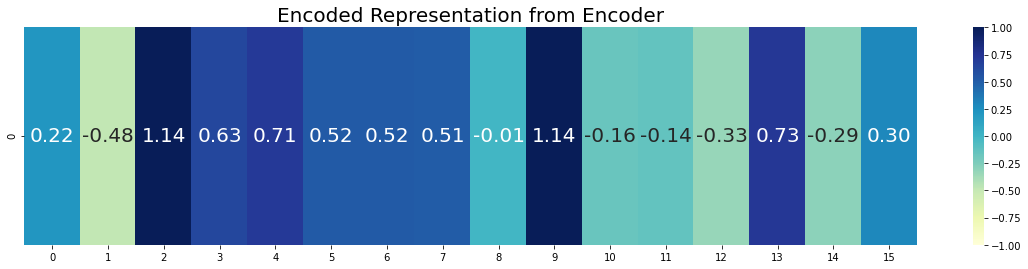

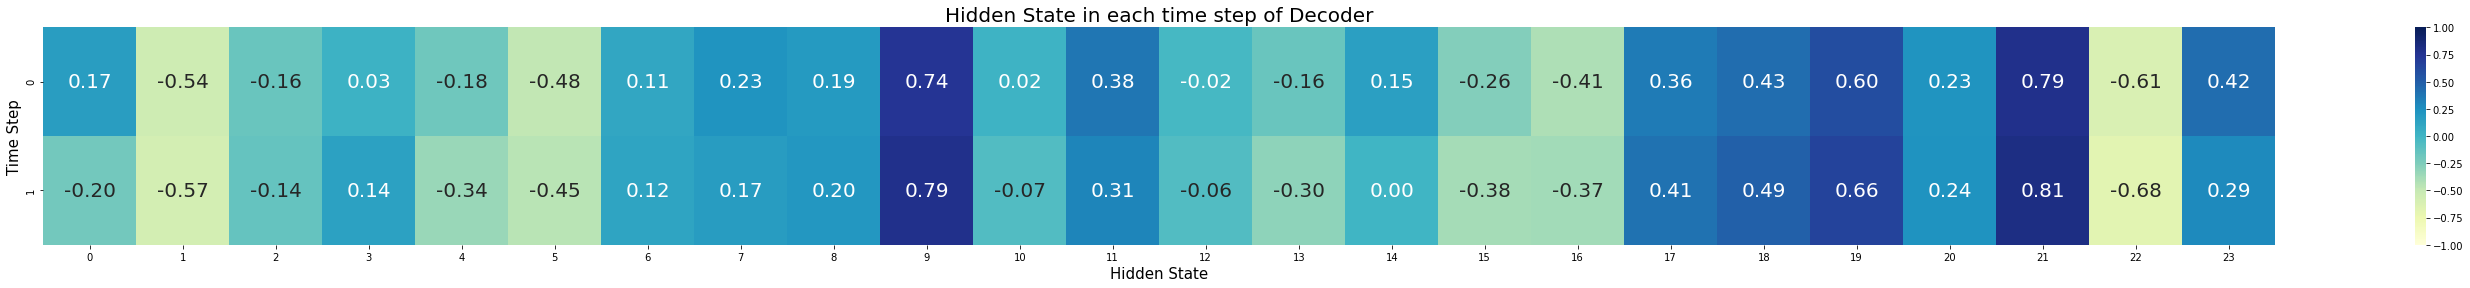

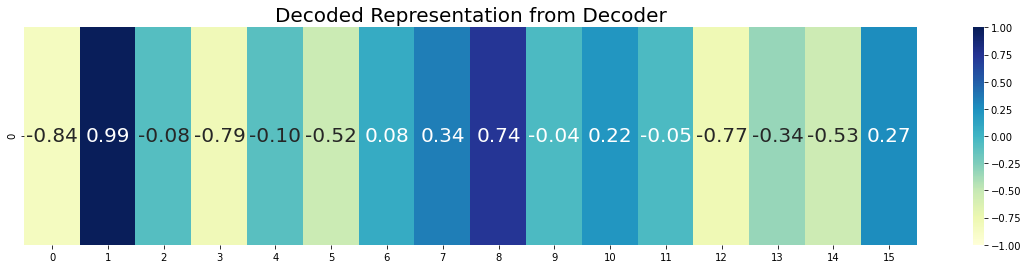

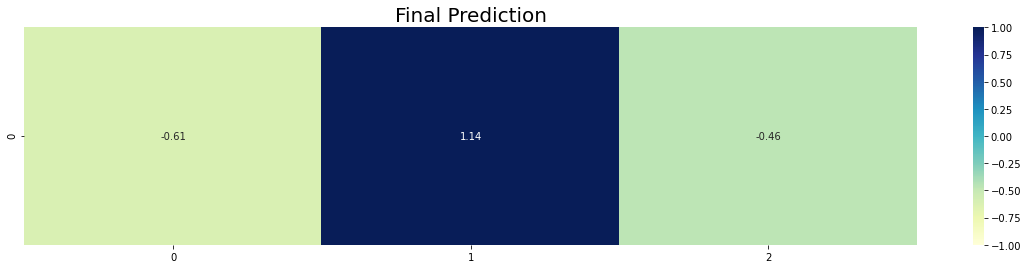

Predicted Label: 1


In [226]:
label, tweet = tweets_data.loc[0]['labels'], tweets_data.loc[0]['tweets']
print(tweet)
print(f'Target Label: {label}')
pred = classify_text(tweet)
print(f'Predicted Label: {pred}')

#### Evaluation Result

In [227]:
eval_df = evaluation_pred(model, valid_iterator)

(<Figure size 576x576 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f82e4c6e610>)

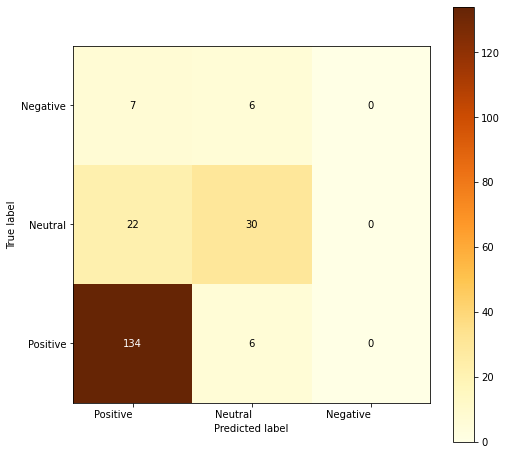

In [228]:
plot_confusion_matrix(eval_df['label'].values.tolist(), eval_df['pred'].values.tolist())

In [229]:
f1_macro, acc = print_accuracy(eval_df, 'label', 'pred')
print(f'F1 Macro Score: {f1_macro}')
print(f'Accuracy: {acc} %')

F1 Macro Score: 0.5075954403951034
Accuracy: 80.0 %


In [71]:
# model.load_state_dict(torch.load(os.path.join(base_path, 'lepoch10_saved_weights.pt')))
# model = model.to(device)